In [1]:
import pandas as pd
import loaders
import ML
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import average_precision_score
import shap

In [3]:
def permutation_test_between_clfs(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    auc_differences = []
    auc1 = roc_auc_score(y_test.ravel(), pred_proba_1.ravel())
    auc2 = roc_auc_score(y_test.ravel(), pred_proba_2.ravel())
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1.ravel()))
        p1 = np.where(mask, pred_proba_1.ravel(), pred_proba_2.ravel())
        p2 = np.where(mask, pred_proba_2.ravel(), pred_proba_1.ravel())
        auc1 = roc_auc_score(y_test.ravel(), p1)
        auc2 = roc_auc_score(y_test.ravel(), p2)
        auc_differences(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

In [3]:
best_feats = ['L_superiorfrontal_thickavg', 'Lput', 'R_lateralorbitofrontal_thickavg','R_transversetemporal_surfavg']

In [4]:
e,g,h = loaders.load_it_all(age=False, sex=False, split_enigma=False, i_keys=best_feats)
e2,g2,h2 = loaders.load_it_all(age=True, sex=True, split_enigma=False, i_keys=None, scale=False)

/home/sage/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
enigma_ages = np.array([x[0] for x in e2[0]])
enigma_sexes = np.array([x[-5] for x in e2[0]])
enigma_sites = np.array([x[-4] for x in e2[0]])
enigma_truth = e2[1]

ages = np.array([x[0] for x in g2[0]])
sexes = np.array([x[-5] for x in g2[0]])
sites = np.array([x[-4] for x in g2[0]])
truth = g2[1]

In [11]:
a = enigma_sexes[enigma_truth==0]
sum(a==0), sum(a==0)/len(a), len(a)

(554, 0.5770833333333333, 960)

In [12]:
np.mean(enigma_ages[enigma_truth==0])

28.540073560319463

In [13]:
np.mean(enigma_ages[enigma_truth==1])

33.362420820911304

In [14]:
(len(enigma_sexes) - np.sum(enigma_sexes)), (len(enigma_sexes) - np.sum(enigma_sexes)) / len(enigma_sexes)

(1009.0, 0.610774818401937)

In [15]:
np.mean(enigma_ages), np.std(enigma_ages)

(30.560088272383354, 10.016346965338688)

In [16]:
np.mean(ages), np.std(ages)

(43.25130890052356, 11.741530794883532)

In [17]:
np.unique(enigma_sites)

array([ 1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 14., 15., 16., 17., 19.,
       20., 22., 23., 24., 25., 27., 28., 29., 30., 31., 32.])

In [18]:
len(enigma_sexes)

1652

In [19]:
e2[1]

array([1, 1, 1, ..., 0, 0, 0])

In [20]:
sum(e2[1][enigma_sexes==0])
#len(e2[1][enigma_sexes==0])

423

In [21]:
np.sum(e2[1][enigma_sexes==0]) / len(e2[1][enigma_sexes==0])

0.4329580348004094

In [22]:
np.sum(e2[1][enigma_sexes==1]) / len(e2[1][enigma_sexes==1])

0.3436988543371522

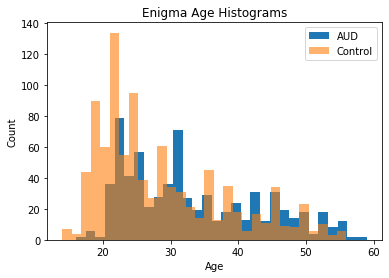

In [23]:
plt.hist(enigma_ages[e2[1]==1], label = 'AUD', alpha=1, bins=30)
plt.hist(enigma_ages[e2[1]==0], label = 'Control', alpha=.6, bins=30)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Enigma Age Histograms')
plt.savefig('Enigma_Age_Distribution.jpg')

In [13]:
model = ML.train_model(e[0], e[1], classifier='log', param_comb=3, int_folds=5)
    
preds = model.predict_proba(g[0])
preds = np.array([p[1] for p in preds])

r_preds = model.predict_proba(e[0])
r_preds = np.array([p[1] for p in r_preds])

binary_preds = model.predict(g[0])

truth = g[1]
r_truth = e[1]

In [8]:
from sklearn.metrics import roc_auc_score

In [10]:
model = ML.train_model(e[0], e[1], classifier='log', param_comb=3, int_folds=5)

0.7681390759229161

In [25]:
from scipy.stats import mannwhitneyu

In [49]:
def get_score(model, X, y):
    
    preds = model.predict_proba(X)
    preds = np.array([p[1] for p in preds])
    score = roc_auc_score(y, preds)
    
    return score
    
base_X = g[0]
base_y = g[1]

base_line = get_score(model, base_X, base_y)
other_score = np.mean([get_score(model, base_X, np.random.permutation(base_y)) for i in range(1000000)])
other_score

0.5000602473299279

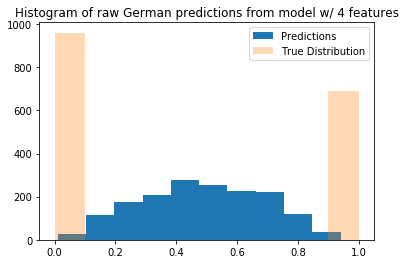

In [43]:
plt.hist(r_preds, label='Predictions')
plt.hist(r_truth, alpha=.3, label='True Distribution')
plt.legend()
plt.title('Histogram of raw German predictions from model w/ 4 features')
plt.savefig('German_Ref_preds.jpg')

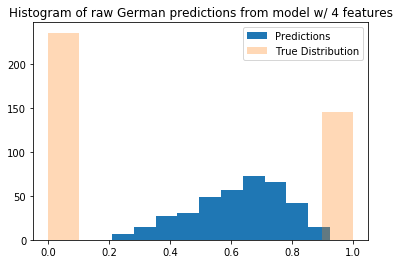

In [26]:
plt.hist(preds, label='Predictions')
plt.hist(truth, alpha=.3, label='True Distribution')
plt.legend()
plt.title('Histogram of raw German predictions from model w/ 4 features')
plt.savefig('German_Ref_preds.jpg')

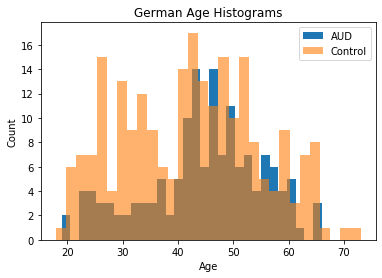

In [10]:
plt.hist(ages[g2[1]==1], label = 'AUD', alpha=1, bins=30)
plt.hist(ages[g2[1]==0], label = 'Control', alpha=.6, bins=30)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('German Age Histograms')
plt.savefig('German_Age_Distribution.jpg')

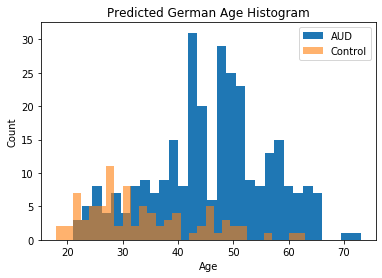

In [11]:
plt.hist(ages[binary_preds==1], label = 'AUD', alpha=1, bins=30)
plt.hist(ages[binary_preds==0], label = 'Control', alpha=.6, bins=30)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Predicted German Age Histogram')
plt.savefig('Binary_Predicted_German.jpg')

In [17]:
preds_sex0 = preds[sexes == 0.0]
truth_sex0 = truth[sexes == 0.0]
preds_sex1 = preds[sexes == 1.0]
truth_sex1 = truth[sexes == 1.0]

preds_younger = preds[ages <= np.median(ages)]
truth_younger = truth[ages <= np.median(ages)]
preds_older = preds[ages > np.mean(ages)]
truth_older = truth[ages > np.mean(ages)]

preds_site1 = preds[sites==50]
truth_site1 = truth[sites==50]
preds_site2 = preds[sites==51]
truth_site2 = truth[sites==51]
preds_site3 = preds[sites==52]
truth_site3 = truth[sites==52]

n_all = str(len(preds))
n_sex0, n_sex1 = str(len(preds_sex0)), str(len(preds_sex1))
n_younger, n_older = str(len(preds_younger)), str(len(preds_older))
n_site1, n_site2, n_site3 = str(len(preds_site1)), str(len(preds_site2)), str(len(preds_site3))

In [18]:
print('mean age: ', np.mean(ages))

mean age:  43.25130890052356


In [19]:
fpr, tpr, _ = roc_curve(truth, preds)
roc_auc = auc(fpr, tpr)

fpr_sex0, tpr_sex0, _ = roc_curve(truth_sex0, preds_sex0)
roc_auc_sex0 = auc(fpr_sex0, tpr_sex0)
fpr_sex1, tpr_sex1, _ = roc_curve(truth_sex1, preds_sex1)
roc_auc_sex1 = auc(fpr_sex1, tpr_sex1)

fpr_younger, tpr_younger, _ = roc_curve(truth_younger, preds_younger)
roc_auc_younger = auc(fpr_younger, tpr_younger)
fpr_older, tpr_older, _ = roc_curve(truth_older, preds_older)
roc_auc_older = auc(fpr_older, tpr_older)

fpr_site1, tpr_site1, _ = roc_curve(truth_site1, preds_site1)
roc_auc_site1 = auc(fpr_site1, tpr_site1)
fpr_site2, tpr_site2, _ = roc_curve(truth_site2, preds_site2)
roc_auc_site2 = auc(fpr_site2, tpr_site2)
fpr_site3, tpr_site3, _ = roc_curve(truth_site3, preds_site3)
roc_auc_site3 = auc(fpr_site3, tpr_site3)

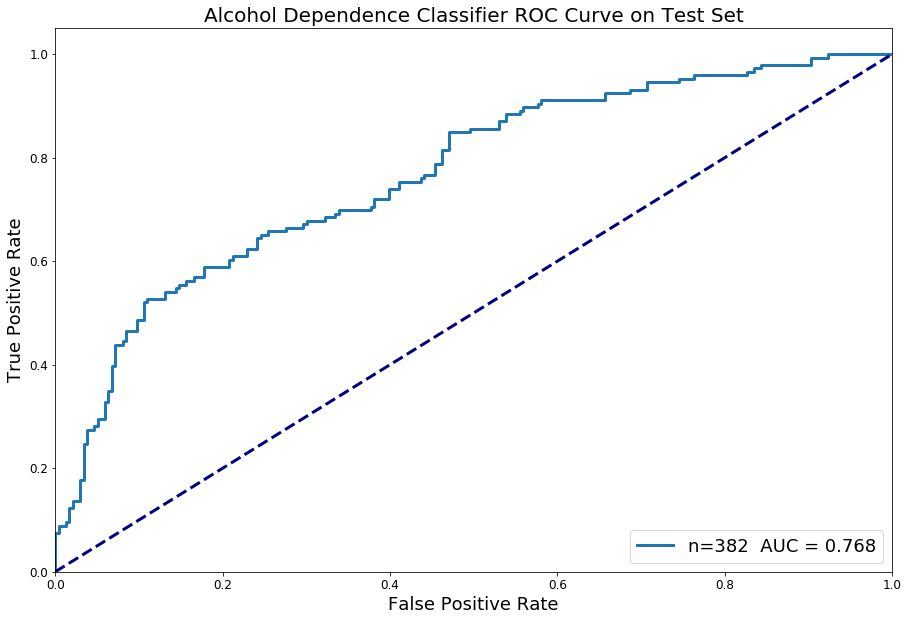

In [24]:
#plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))
lw = 3

plt.plot(fpr, tpr,lw=lw,                 label='n=' + n_all + '  ' + 'AUC = %.3f' % roc_auc)
#plt.plot(fpr_sex0, tpr_sex0,lw=lw,       label='Female               (n=' + n_sex0 + ')  ' + 'AUC = %.3f' % roc_auc_sex0)
#plt.plot(fpr_sex1, tpr_sex1,lw=lw,       label='Male                   (n=' + n_sex1 + ')  ' + 'AUC = %.3f' % roc_auc_sex1)
#plt.plot(fpr_younger, tpr_younger,lw=lw, label='44 and younger  (n=' + n_younger + ')  ' + 'AUC = %.3f' % roc_auc_younger)
#plt.plot(fpr_older, tpr_older,lw=lw,     label='45 and older       (n=' + n_older + ')  ' + 'AUC = %.3f' % roc_auc_older)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Alcohol Dependence Classifier ROC Curve on Test Set', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.savefig('ROC_Curve.pdf', transparent=False, dpi=1000)

plt.tick_params(labelsize=12)
plt.show()

In [ ]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))
lw = 3

plt.plot(fpr, tpr,lw=lw,                 label='All  (n=' + n_all + ')  ' + 'AUC = %.3f' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Alcohol Dependence Classifier ROC Curve on Test Set', fontsize=20)
plt.legend(loc="lower right", fontsize=20)
plt.savefig('All.jpg', dpi=100)
plt.show()

In [ ]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))
lw = 3

plt.plot(fpr_younger, tpr_younger,lw=lw, label='44 and younger  (n=' + n_younger + ')  ' + 'AUC = %.3f' % roc_auc_younger)
plt.plot(fpr_older, tpr_older,lw=lw,     label='45 and older       (n=' + n_older + ')  ' + 'AUC = %.3f' % roc_auc_older)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Age Comparison ROC Curve on Test Set', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.savefig('Age.jpg', dpi=100)
plt.show()

In [ ]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))
lw = 3

plt.plot(fpr_sex0, tpr_sex0,lw=lw,       label='Male      (n=' + n_sex0 + ')  ' + 'AUC = %.3f' % roc_auc_sex0)
plt.plot(fpr_sex1, tpr_sex1,lw=lw,       label='Female  (n=' + n_sex1 + ')  ' + 'AUC = %.3f' % roc_auc_sex1)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Sex Comparison ROC Curve on Test Set', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.savefig('Sex.jpg', dpi=100)
plt.show()

In [ ]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))
lw = 3

plt.plot(fpr_site1, tpr_site1,lw=lw,       label='Site 1  (n=' + n_site1 + ')  ' + 'AUC = %.3f' % roc_auc_site1)
plt.plot(fpr_site2, tpr_site2,lw=lw,       label='Site 2  (n=' + n_site2 + ')  ' + 'AUC = %.3f' % roc_auc_site2)
plt.plot(fpr_site3, tpr_site3,lw=lw,       label='Site 3  (n=' + n_site3 + ')  ' + 'AUC = %.3f' % roc_auc_site3)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Site Comparison ROC Curve on Test Set', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.savefig('Site.jpg', dpi=100)
plt.show()

In [ ]:



average_precision = average_precision_score(truth, preds)

precision, recall, _ = precision_recall_curve(truth, preds)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
y = [.778, .757, .782, .768, .737, .724, .715, .748, .738, .741]

In [ ]:
x = [1,2,3,4,5,6,7,8,9,10]

In [ ]:
plt.plot(x,y)